In [472]:
'''
This block is used to import all libraries we will use in the project
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, scale, minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from numpy import array
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

In [336]:
'''
This block is used to define all function we will use in the project
'''


def create_data(data_X, data_Y, number_X, number_Y):
    '''
    Basic idea:
    create several sub-dataframes and concat them together.
    For instance:
    Samples : 1,2,3,4,5,6,7
    number X = 3
    number Y = 2
    
    for measurements, create data frames:
    1    |    2    |    3
    2    |    3    |    4
    3    |    4    |    5
    
    Then concat them together, we can get 3 new sample measurements:
    
    Sample 1: 1, 2, 3
    Sample 2: 2, 3, 4
    Sample 3: 3, 4, 5
    '''
    
    # to get the coloumn names
    features_name = [col for col in data_X]
    target_name = [col for col in data_Y]
    X_shape = data_X.shape
    index_X = data_X.index
    number_samples = X_shape[0]
    
    number_to_delete = number_X + number_Y -1
    number_measurements = number_samples - number_to_delete
    temp_X = []
    rst_df = None
    rst_index = None
    # create number_X dataframes and concat them together
    # for each dataframe, we should delete number_X -1 entries
    # create the delete lish
    for i in range(number_X):
        data_copy = data_X.copy()
        '''
        del_list contains the index of samples which should be deleted for each sub-dataframes
        '''
        del_list = []
        
        for j in range(i):
            del_list.append(index_X[j])
        for k in range(number_to_delete - i):
            del_list.append(index_X[number_samples - k -1])
        if i == 0:
            # the first sub-dataframe, create it directly
            rst_df = data_copy.drop(del_list, axis=0)
            rst_df.columns = [j+str(i) for j in features_name]
            rst_index = rst_df.index
        else:
            # concat the new sub-dataframe with the previous result
#             print(del_list)
            temp_df = data_copy.drop(del_list, axis=0)
            temp_df.index = rst_index
            temp_df.columns = [j+str(i) for j in features_name]
            rst_df = pd.concat([rst_df, temp_df], axis=1)
#             print(rst_df.shape)
            
    for i in range(number_Y):
        target_copy = data_Y.copy()
        del_list = []
        for j in range(number_X + i -1):
            del_list.append(index_X[j])
        for k in range(number_Y - i):
            del_list.append(index_X[number_samples - k -1])
#         print(del_list)
        if i == 0:
            tgt_df = target_copy.drop(del_list, axis=0)
            tgt_df.columns = [j+str(i) for j in target_name]
            tgt_index = tgt_df.index
        else:
#             print(del_list)
            temp_df = target_copy.drop(del_list, axis=0)
            temp_df.index = tgt_index
            temp_df.columns = [j+str(i) for j in target_name]
            tgt_df = pd.concat([tgt_df, temp_df], axis=1)
            print(tgt_df.shape)
    return rst_df, tgt_df


def RNN_reshape(data, number_X, n_features):
    X = data.to_numpy()
    X = X.reshape(X.shape[0], number_X, n_features)
    return X


def BuildRNN_Multi_Step_LSTM(input_X, input_Y, number_X, number_Y, n_features):
    X = RNN_reshape(input_X, number_X, n_features)
#     print(X)
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(number_X, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(number_Y))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(X, input_Y, epochs=100, verbose=1, batch_size=1000)
    return model

def Build_Encoder_Decoder_LSTM(input_X, input_Y, number_X, number_Y, n_features, n_target):
    X = RNN_reshape(input_X, number_X, n_features)
    Y = RNN_reshape(input_Y, number_Y, n_target)
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(number_X, 16)))
    model.add(RepeatVector(number_Y))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(X, Y, epochs=100, verbose=1, batch_size=1000)
    return model


# input data should be np array, only outliers in X will be considered
def OutlierRemoval(InputX, InputY, Threhold):
    
    Y_FeatureColumn = [i for i in range(len(InputX[0]), len(InputX[0]) + len(InputY[0]))]
    
    # combine X and Y
    combine_data = np.c_[InputX, InputY]
    
    # remove outlier in X
    removed_data = combine_data[np.all(np.abs(np.delete(combine_data, Y_FeatureColumn, 1)) < Threhold ,axis=1)]
    
    # spilit removed_data into X and Y
    removed_x = np.delete(removed_data, Y_FeatureColumn, 1)
    removed_y = removed_data[:,Y_FeatureColumn]
    
    return removed_x, removed_y

# All input data should be np array
def CalculateNMAE(PredictData, TestData):
    return mean_absolute_error(PredictData, TestData)/TestData.mean()


# feature selection, only return X since we don't change Y
def TreeBasedSelection(InputX, InputY, FeatureNumber):
    # create and fit selector
    clf = ExtraTreesRegressor()
    clf = clf.fit(InputX, InputY)
    
    # only number of sorted features will be selected, and we disable threshold
    model = SelectFromModel(clf, prefit=True, max_features = FeatureNumber, threshold=-np.inf)
    OutputX = model.transform(InputX)
    return OutputX

# standardize column value
def ColumnStandardize(Input):
    Scaler = StandardScaler()
    return Scaler.fit_transform(Input)

In [7]:
'''
Read data from file
'''
# fileName_X = '../VoD_Periodic_2017/X.csv'
# fileName_Y = '../VoD_Periodic_2017/Y.csv'
fileName_X = '../KV_flash/X.csv'
fileName_Y = '../KV_flash/Y.csv'
# fileName_X = './KV_flash/VOD_X.csv'
# fileName_Y = './KV_flash/VOD_Y.csv'
# fileName_X = '../X.csv'
# fileName_Y = '../Y.csv'
# fileName_X = './VoD_flash/X.csv'
# fileName_Y = './VoD_flash/Y.csv'

In [8]:
'''
Read data from csv file.
X and Y are raw data
Y_notime and Y_notime are data without timestamp
X_features are a list which contains the name of all of the features in X
'''
X = pd.read_csv(fileName_X)
Y = pd.read_csv(fileName_Y)[['TimeStamp', 'WritesAvg']]
# Y = pd.read_csv(fileName_Y)[['TimeStamp', 'DispFrames']]
X_notime = X.drop('TimeStamp',axis=1)
Y_notime = Y.drop(['TimeStamp'],axis=1)
timeIndex_x=pd.to_datetime(X['TimeStamp'])
timeIndex_y=pd.to_datetime(Y['TimeStamp'])
X.index=timeIndex_x
Y.index=timeIndex_y
X_notime.index = timeIndex_x
Y_notime.index = timeIndex_y
X_features = [col for col in X_notime]
np.random.seed(0)

In [9]:
# change from dataframe to np array
X_npArray = X_notime.to_numpy()
Y_npArray = Y_notime.to_numpy()

# standardize the data
X_Standard = ColumnStandardize(X_npArray)

# remove outlier with threshold 100
X_NoOutlier, Y_NoOutlier = OutlierRemoval(X_Standard, Y_npArray, 100)

# tree based feature selection and have only 16 features
X_FeatureSelection = TreeBasedSelection(X_NoOutlier, Y_NoOutlier, 16)

/home/yao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/yao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [10]:
# change X from np array back to dataframe

feature_name = []
for i in range(16):
    feature_name.append('feature'+str(i+1))
    
X_BackToDF = pd.DataFrame(data = X_FeatureSelection,  columns=feature_name)

Y_BackToDF = pd.DataFrame(data = Y_NoOutlier,  columns=Y_notime.columns)

In [11]:
# train set split and sort by index

X_train, X_test, Y_train, Y_test = train_test_split(X_BackToDF, Y_BackToDF, test_size=0.3, random_state=1)
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)

In [17]:
'''
Task 1, train the data using linear regression model
'''

Linear = LinearRegression()
NMAE_table = []

for h in range(1, 12):
    temp_list = []
    print(NMAE_table)
    for l in range(1, 12):
        xtrain, ytrain = create_data(X_train, Y_train, l, h)
        xtest, ytest = create_data(X_test, Y_test, l, h)
        Linear.fit(xtrain, ytrain)
        pred = Linear.predict(xtest)
        temp_list.append(round(CalculateNMAE(pred, ytest)[0], 4))
    NMAE_table.append(temp_list)

[]
[[0.108, 0.107, 0.1066, 0.1063, 0.1061, 0.1061, 0.1062, 0.1061, 0.1061, 0.1062, 0.1063]]
(25873, 2)
(11088, 2)
(25872, 2)
(11087, 2)
(25871, 2)
(11086, 2)
(25870, 2)
(11085, 2)
(25869, 2)
(11084, 2)
(25868, 2)
(11083, 2)
(25867, 2)
(11082, 2)
(25866, 2)
(11081, 2)
(25865, 2)
(11080, 2)
(25864, 2)
(11079, 2)
(25863, 2)
(11078, 2)
[[0.108, 0.107, 0.1066, 0.1063, 0.1061, 0.1061, 0.1062, 0.1061, 0.1061, 0.1062, 0.1063], [0.108, 0.1071, 0.1067, 0.1064, 0.1062, 0.1062, 0.1063, 0.1062, 0.1062, 0.1063, 0.1065]]
(25872, 2)
(25872, 3)
(11087, 2)
(11087, 3)
(25871, 2)
(25871, 3)
(11086, 2)
(11086, 3)
(25870, 2)
(25870, 3)
(11085, 2)
(11085, 3)
(25869, 2)
(25869, 3)
(11084, 2)
(11084, 3)
(25868, 2)
(25868, 3)
(11083, 2)
(11083, 3)
(25867, 2)
(25867, 3)
(11082, 2)
(11082, 3)
(25866, 2)
(25866, 3)
(11081, 2)
(11081, 3)
(25865, 2)
(25865, 3)
(11080, 2)
(11080, 3)
(25864, 2)
(25864, 3)
(11079, 2)
(11079, 3)
(25863, 2)
(25863, 3)
(11078, 2)
(11078, 3)
(25862, 2)
(25862, 3)
(11077, 2)
(11077, 3)
[[0.

(25863, 2)
(25863, 3)
(25863, 4)
(25863, 5)
(25863, 6)
(25863, 7)
(25863, 8)
(11078, 2)
(11078, 3)
(11078, 4)
(11078, 5)
(11078, 6)
(11078, 7)
(11078, 8)
(25862, 2)
(25862, 3)
(25862, 4)
(25862, 5)
(25862, 6)
(25862, 7)
(25862, 8)
(11077, 2)
(11077, 3)
(11077, 4)
(11077, 5)
(11077, 6)
(11077, 7)
(11077, 8)
(25861, 2)
(25861, 3)
(25861, 4)
(25861, 5)
(25861, 6)
(25861, 7)
(25861, 8)
(11076, 2)
(11076, 3)
(11076, 4)
(11076, 5)
(11076, 6)
(11076, 7)
(11076, 8)
(25860, 2)
(25860, 3)
(25860, 4)
(25860, 5)
(25860, 6)
(25860, 7)
(25860, 8)
(11075, 2)
(11075, 3)
(11075, 4)
(11075, 5)
(11075, 6)
(11075, 7)
(11075, 8)
(25859, 2)
(25859, 3)
(25859, 4)
(25859, 5)
(25859, 6)
(25859, 7)
(25859, 8)
(11074, 2)
(11074, 3)
(11074, 4)
(11074, 5)
(11074, 6)
(11074, 7)
(11074, 8)
(25858, 2)
(25858, 3)
(25858, 4)
(25858, 5)
(25858, 6)
(25858, 7)
(25858, 8)
(11073, 2)
(11073, 3)
(11073, 4)
(11073, 5)
(11073, 6)
(11073, 7)
(11073, 8)
(25857, 2)
(25857, 3)
(25857, 4)
(25857, 5)
(25857, 6)
(25857, 7)
(25857, 8)

(25861, 2)
(25861, 3)
(25861, 4)
(25861, 5)
(25861, 6)
(25861, 7)
(25861, 8)
(25861, 9)
(25861, 10)
(25861, 11)
(11076, 2)
(11076, 3)
(11076, 4)
(11076, 5)
(11076, 6)
(11076, 7)
(11076, 8)
(11076, 9)
(11076, 10)
(11076, 11)
(25860, 2)
(25860, 3)
(25860, 4)
(25860, 5)
(25860, 6)
(25860, 7)
(25860, 8)
(25860, 9)
(25860, 10)
(25860, 11)
(11075, 2)
(11075, 3)
(11075, 4)
(11075, 5)
(11075, 6)
(11075, 7)
(11075, 8)
(11075, 9)
(11075, 10)
(11075, 11)
(25859, 2)
(25859, 3)
(25859, 4)
(25859, 5)
(25859, 6)
(25859, 7)
(25859, 8)
(25859, 9)
(25859, 10)
(25859, 11)
(11074, 2)
(11074, 3)
(11074, 4)
(11074, 5)
(11074, 6)
(11074, 7)
(11074, 8)
(11074, 9)
(11074, 10)
(11074, 11)
(25858, 2)
(25858, 3)
(25858, 4)
(25858, 5)
(25858, 6)
(25858, 7)
(25858, 8)
(25858, 9)
(25858, 10)
(25858, 11)
(11073, 2)
(11073, 3)
(11073, 4)
(11073, 5)
(11073, 6)
(11073, 7)
(11073, 8)
(11073, 9)
(11073, 10)
(11073, 11)
(25857, 2)
(25857, 3)
(25857, 4)
(25857, 5)
(25857, 6)
(25857, 7)
(25857, 8)
(25857, 9)
(25857, 10)
(258

In [40]:
'''
Try using naive method
'''
y_naive = pd.DataFrame({'result':[Y_train.mean()]*len(Y_test)})

In [41]:
CalculateNMAE(y_naive, Y_test)

WritesAvg    0.041062
dtype: float64

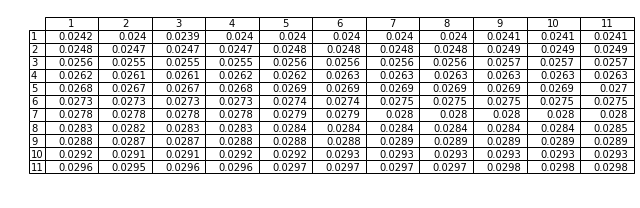

In [305]:
ColLable = [i for i in range(1, 12)]
RowLable = [i for i in range(1, 12)]
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('off')
ax.axis('tight')

ax.table(cellText=NMAE_table, rowLabels= RowLable, colLabels = ColLable, loc='center')
fig.tight_layout()
plt.show()

In [195]:
xtrain, ytrain = create_data(X_train, Y_train, 1, 1)
xtest, ytest = create_data(X_test, Y_test, 1, 1)
Linear = LinearRegression()
Linear.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [196]:
pred = Linear.predict(xtest)

In [197]:
# print(CalculateNMAE(pred[:,1], ytest['WritesAvg1']))
print(CalculateNMAE(pred[:,0], ytest['WritesAvg0']))
print(CalculateNMAE(pred, ytest))

0.024153412894430955
WritesAvg0    0.024153
dtype: float64


In [65]:
RNN_NMAE_table = []
for h in range(1, 12):
    temp_list = []
    print(RNN_NMAE_table)
    for l in range(1, 12):
        RNN_xtrain, RNN_ytrain = create_data(X_train, Y_train, l, h)
        RNN_xtest, RNN_ytest = create_data(X_test, Y_test, l, h)
        RNNmodel = BuildRNN_Multi_Step_LSTM(RNN_xtrain, RNN_ytrain, l, h, 16)
        RNNtest = RNN_reshape(RNN_xtest, l, 16)
        RNNpred = RNNmodel.predict(RNNtest)
        temp_list.append(round(np.mean(CalculateNMAE(RNNpred, RNN_ytest)), 4))
    RNN_NMAE_table.append(temp_list)

[]
Epoch 1/50
13553/13553 [==============================] - 14s 1ms/step - loss: 12216.5020
Epoch 2/50
13553/13553 [==============================] - 1s 62us/step - loss: 12151.9588
Epoch 3/50
13553/13553 [==============================] - 1s 61us/step - loss: 11851.1795
Epoch 4/50
13553/13553 [==============================] - 1s 62us/step - loss: 10423.5830
Epoch 5/50
13553/13553 [==============================] - 1s 61us/step - loss: 6905.1543
Epoch 6/50
13553/13553 [==============================] - 1s 61us/step - loss: 3485.5468
Epoch 7/50
13553/13553 [==============================] - 1s 61us/step - loss: 2382.4755
Epoch 8/50
13553/13553 [==============================] - 1s 60us/step - loss: 2133.3476
Epoch 9/50
13553/13553 [==============================] - 1s 59us/step - loss: 1916.6729
Epoch 10/50
13553/13553 [==============================] - 1s 62us/step - loss: 1732.7036
Epoch 11/50
13553/13553 [==============================] - 1s 62us/step - loss: 1571.5264
Epoch 12/50


Epoch 34/50
13550/13550 [==============================] - 3s 200us/step - loss: 15.5532
Epoch 35/50
13550/13550 [==============================] - 3s 201us/step - loss: 15.3595
Epoch 36/50
13550/13550 [==============================] - 3s 200us/step - loss: 15.0691
Epoch 37/50
13550/13550 [==============================] - 3s 205us/step - loss: 14.8335
Epoch 38/50
13550/13550 [==============================] - 3s 201us/step - loss: 14.7424
Epoch 39/50
13550/13550 [==============================] - 3s 203us/step - loss: 14.6268
Epoch 40/50
13550/13550 [==============================] - 3s 200us/step - loss: 14.6089
Epoch 41/50
13550/13550 [==============================] - 3s 202us/step - loss: 14.6694
Epoch 42/50
13550/13550 [==============================] - 3s 201us/step - loss: 14.6156
Epoch 43/50
13550/13550 [==============================] - 3s 202us/step - loss: 14.5328
Epoch 44/50
13550/13550 [==============================] - 3s 207us/step - loss: 14.9080
Epoch 45/50
13550/135

13548/13548 [==============================] - 4s 295us/step - loss: 15.1210
Epoch 27/50
13548/13548 [==============================] - 4s 296us/step - loss: 15.1890
Epoch 28/50
13548/13548 [==============================] - 4s 297us/step - loss: 14.9179
Epoch 29/50
13548/13548 [==============================] - 4s 294us/step - loss: 14.5561
Epoch 30/50
13548/13548 [==============================] - 4s 298us/step - loss: 14.4876
Epoch 31/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.6368
Epoch 32/50
13548/13548 [==============================] - 4s 298us/step - loss: 15.2450
Epoch 33/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.8677
Epoch 34/50
13548/13548 [==============================] - 4s 299us/step - loss: 14.3411
Epoch 35/50
13548/13548 [==============================] - 4s 298us/step - loss: 14.1401
Epoch 36/50
13548/13548 [==============================] - 4s 303us/step - loss: 14.1171
Epoch 37/50
13548/13548 [========

13544/13544 [==============================] - 7s 497us/step - loss: 16.3741
Epoch 11/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.9293
Epoch 12/50
13544/13544 [==============================] - 7s 497us/step - loss: 16.4933
Epoch 13/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.5518
Epoch 14/50
13544/13544 [==============================] - 7s 499us/step - loss: 15.1362
Epoch 15/50
13544/13544 [==============================] - 7s 501us/step - loss: 15.1136
Epoch 16/50
13544/13544 [==============================] - 7s 499us/step - loss: 15.1509
Epoch 17/50
13544/13544 [==============================] - 7s 498us/step - loss: 15.3933
Epoch 18/50
13544/13544 [==============================] - 7s 499us/step - loss: 14.7501
Epoch 19/50
13544/13544 [==============================] - 7s 499us/step - loss: 14.1874
Epoch 20/50
13544/13544 [==============================] - 7s 500us/step - loss: 14.5555
Epoch 21/50
13544/13544 [========

13552/13552 [==============================] - 22s 2ms/step - loss: 12221.6155
Epoch 2/50
13552/13552 [==============================] - 1s 62us/step - loss: 12168.0690
Epoch 3/50
13552/13552 [==============================] - 1s 63us/step - loss: 11875.5096
Epoch 4/50
13552/13552 [==============================] - 1s 62us/step - loss: 10565.7966
Epoch 5/50
13552/13552 [==============================] - 1s 62us/step - loss: 7962.5831
Epoch 6/50
13552/13552 [==============================] - 1s 62us/step - loss: 5090.9134
Epoch 7/50
13552/13552 [==============================] - 1s 62us/step - loss: 3117.2532
Epoch 8/50
13552/13552 [==============================] - 1s 63us/step - loss: 2107.2099
Epoch 9/50
13552/13552 [==============================] - 1s 61us/step - loss: 1885.2366
Epoch 10/50
13552/13552 [==============================] - 1s 62us/step - loss: 1694.8306
Epoch 11/50
13552/13552 [==============================] - 1s 62us/step - loss: 1548.5759
Epoch 12/50
13552/13552 [=

13549/13549 [==============================] - 3s 209us/step - loss: 16.8602
Epoch 34/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.5506
Epoch 35/50
13549/13549 [==============================] - 4s 269us/step - loss: 16.2822
Epoch 36/50
13549/13549 [==============================] - 3s 211us/step - loss: 16.1540
Epoch 37/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.0082
Epoch 38/50
13549/13549 [==============================] - 3s 208us/step - loss: 16.0601
Epoch 39/50
13549/13549 [==============================] - 3s 210us/step - loss: 15.9468
Epoch 40/50
13549/13549 [==============================] - 3s 209us/step - loss: 16.2619
Epoch 41/50
13549/13549 [==============================] - 3s 209us/step - loss: 16.2746
Epoch 42/50
13549/13549 [==============================] - 3s 211us/step - loss: 16.1168
Epoch 43/50
13549/13549 [==============================] - 3s 216us/step - loss: 15.8806
Epoch 44/50
13549/13549 [========

13545/13545 [==============================] - 6s 408us/step - loss: 17.9700
Epoch 16/50
13545/13545 [==============================] - 5s 406us/step - loss: 17.2342
Epoch 17/50
13545/13545 [==============================] - 5s 405us/step - loss: 17.6470
Epoch 18/50
13545/13545 [==============================] - 6s 406us/step - loss: 19.2141
Epoch 19/50
13545/13545 [==============================] - 5s 406us/step - loss: 18.1833
Epoch 20/50
13545/13545 [==============================] - 6s 409us/step - loss: 17.3017
Epoch 21/50
13545/13545 [==============================] - 6s 413us/step - loss: 16.4112
Epoch 22/50
13545/13545 [==============================] - 6s 407us/step - loss: 16.3915
Epoch 23/50
13545/13545 [==============================] - 6s 407us/step - loss: 17.0534
Epoch 24/50
13545/13545 [==============================] - 6s 409us/step - loss: 17.1302
Epoch 25/50
13545/13545 [==============================] - 6s 407us/step - loss: 17.4189
Epoch 26/50
13545/13545 [========

13542/13542 [==============================] - 8s 554us/step - loss: 15.9455
Epoch 49/50
13542/13542 [==============================] - 8s 555us/step - loss: 16.1921
Epoch 50/50
13542/13542 [==============================] - 8s 562us/step - loss: 15.4244
[[0.042, 0.0275, 0.025, 0.0263, 0.0248, 0.024, 0.0253, 0.0265, 0.0251, 0.0278, 0.027], [0.0479, 0.0266, 0.0254, 0.0266, 0.0255, 0.0247, 0.0262, 0.0263, 0.0272, 0.0264, 0.0258]]
(13551, 2)
(13551, 3)
(5807, 2)
(5807, 3)
Epoch 1/50
13551/13551 [==============================] - 28s 2ms/step - loss: 12222.7327
Epoch 2/50
13551/13551 [==============================] - 1s 65us/step - loss: 12179.7466
Epoch 3/50
13551/13551 [==============================] - 1s 64us/step - loss: 11942.2822
Epoch 4/50
13551/13551 [==============================] - 1s 63us/step - loss: 10804.0391
Epoch 5/50
13551/13551 [==============================] - 1s 64us/step - loss: 8405.1186
Epoch 6/50
13551/13551 [==============================] - 1s 65us/step - loss

13548/13548 [==============================] - 3s 208us/step - loss: 20.2114
Epoch 28/50
13548/13548 [==============================] - 3s 208us/step - loss: 19.7850
Epoch 29/50
13548/13548 [==============================] - 3s 207us/step - loss: 19.5348
Epoch 30/50
13548/13548 [==============================] - 3s 208us/step - loss: 19.1598
Epoch 31/50
13548/13548 [==============================] - 3s 210us/step - loss: 18.9781
Epoch 32/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.5918
Epoch 33/50
13548/13548 [==============================] - 3s 209us/step - loss: 18.3898
Epoch 34/50
13548/13548 [==============================] - 3s 209us/step - loss: 18.3553
Epoch 35/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.2817
Epoch 36/50
13548/13548 [==============================] - 3s 208us/step - loss: 18.3660
Epoch 37/50
13548/13548 [==============================] - 3s 207us/step - loss: 18.3508
Epoch 38/50
13548/13548 [========

13544/13544 [==============================] - 5s 400us/step - loss: 25.6537
Epoch 10/50
13544/13544 [==============================] - 5s 405us/step - loss: 24.2475
Epoch 11/50
13544/13544 [==============================] - 5s 404us/step - loss: 23.8081
Epoch 12/50
13544/13544 [==============================] - 5s 403us/step - loss: 22.5240
Epoch 13/50
13544/13544 [==============================] - 5s 406us/step - loss: 21.7817
Epoch 14/50
13544/13544 [==============================] - 5s 404us/step - loss: 21.3113
Epoch 15/50
13544/13544 [==============================] - 5s 403us/step - loss: 21.3398
Epoch 16/50
13544/13544 [==============================] - 5s 402us/step - loss: 20.3683
Epoch 17/50
13544/13544 [==============================] - 5s 402us/step - loss: 20.4849
Epoch 18/50
13544/13544 [==============================] - 5s 403us/step - loss: 19.9367
Epoch 19/50
13544/13544 [==============================] - 5s 405us/step - loss: 19.5790
Epoch 20/50
13544/13544 [========

KeyboardInterrupt: 

In [ ]:
RNN_Encoder_NMAE_table = []
for h in range(1, 12):
    temp_list = []
    print(RNN_Encoder_NMAE_table)
    for l in range(1, 12):
        RNN_xtrain, RNN_ytrain = create_data(X_train, Y_train, l, h)
        RNN_xtest, RNN_ytest = create_data(X_test, Y_test, l, h)
        RNNmodel = Build_Encoder_Decoder_LSTM(RNN_xtrain, RNN_ytrain, l, h, 16,1 )
        RNNtest = RNN_reshape(RNN_xtest, l, 16)
        RNNpred = RNNmodel.predict(RNNtest)
        RNN_2d_pred = RNNpred.reshape(np.shape(RNN_ytest))
        temp_list.append(round(np.mean(CalculateNMAE(RNN_2d_pred, RNN_ytest)), 4))
    RNN_Encoder_NMAE_table.append(temp_list)

[]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
13553/13553 [==============================] - 7s 515us/step - loss: 12222.1137
Epoch 2/100
13553/13553 [==============================] - 1s 59us/step - loss: 12168.1041
Epoch 3/100
13553/13553 [==============================] - 1s 59us/step - loss: 11882.7103
Epoch 4/100
13553/13553 [==============================] - 1s 59us/step - loss: 10582.9468
Epoch 5/100
13553/13553 [==============================] - 1s 60us/step - loss: 7882.0774
Epoch 6/100
13553/13553 [==============================] - 1s 59us/step - loss: 4810.4309
Epoch 7/100
13553/13553 [==============================] - 1s 59us/step - loss: 2906.1877
Epoch 8/100
13553/13553 [==============================] - 1s 59us/step - loss: 2051.5060
Epoch 9/100
13553/13553 [==============================] - 1s 60us/step - loss: 1887.1724
Epoch 10/100
13553/13553 [==============================] - 1s 60us/step - loss: 1

13552/13552 [==============================] - 1s 81us/step - loss: 11.5138
Epoch 67/100
13552/13552 [==============================] - 1s 82us/step - loss: 11.4750
Epoch 68/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.4170
Epoch 69/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.3290
Epoch 70/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.5343
Epoch 71/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.4086
Epoch 72/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.4990
Epoch 73/100
13552/13552 [==============================] - 1s 82us/step - loss: 11.1614
Epoch 74/100
13552/13552 [==============================] - 1s 80us/step - loss: 11.1449
Epoch 75/100
13552/13552 [==============================] - 1s 82us/step - loss: 11.0818
Epoch 76/100
13552/13552 [==============================] - 1s 81us/step - loss: 11.1850
Epoch 77/100
13552/13552 [========

13550/13550 [==============================] - 2s 124us/step - loss: 11.7932
Epoch 49/100
13550/13550 [==============================] - 2s 123us/step - loss: 11.8065
Epoch 50/100
13550/13550 [==============================] - 2s 124us/step - loss: 12.0080
Epoch 51/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.7144
Epoch 52/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.8686
Epoch 53/100
13550/13550 [==============================] - 2s 123us/step - loss: 11.6097
Epoch 54/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.8863
Epoch 55/100
13550/13550 [==============================] - 2s 126us/step - loss: 11.8299
Epoch 56/100
13550/13550 [==============================] - 2s 123us/step - loss: 11.5231
Epoch 57/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.3776
Epoch 58/100
13550/13550 [==============================] - 2s 124us/step - loss: 11.5274
Epoch 59/100
13550/1355

13549/13549 [==============================] - 2s 147us/step - loss: 12.0566
Epoch 40/100
13549/13549 [==============================] - 2s 147us/step - loss: 12.1736
Epoch 41/100
13549/13549 [==============================] - 2s 146us/step - loss: 11.9553
Epoch 42/100
13549/13549 [==============================] - 2s 145us/step - loss: 12.0028
Epoch 43/100
13549/13549 [==============================] - 2s 145us/step - loss: 11.8553
Epoch 44/100
13549/13549 [==============================] - 2s 146us/step - loss: 12.4793
Epoch 45/100
13549/13549 [==============================] - 2s 147us/step - loss: 11.7905
Epoch 46/100
13549/13549 [==============================] - 2s 146us/step - loss: 11.7093
Epoch 47/100
13549/13549 [==============================] - 2s 148us/step - loss: 11.6013
Epoch 48/100
13549/13549 [==============================] - 2s 146us/step - loss: 11.6680
Epoch 49/100
13549/13549 [==============================] - 2s 147us/step - loss: 11.5594
Epoch 50/100
13549/1354

13548/13548 [==============================] - 2s 169us/step - loss: 12.2275
Epoch 31/100
13548/13548 [==============================] - 2s 167us/step - loss: 12.1009
Epoch 32/100
13548/13548 [==============================] - 2s 169us/step - loss: 11.6440
Epoch 33/100
13548/13548 [==============================] - 2s 168us/step - loss: 11.8495
Epoch 34/100
13548/13548 [==============================] - 2s 168us/step - loss: 11.9931
Epoch 35/100
13548/13548 [==============================] - 2s 168us/step - loss: 12.0745
Epoch 36/100
13548/13548 [==============================] - 2s 168us/step - loss: 12.1722
Epoch 37/100
13548/13548 [==============================] - 2s 169us/step - loss: 12.5850
Epoch 38/100
13548/13548 [==============================] - 2s 169us/step - loss: 11.5335
Epoch 39/100
13548/13548 [==============================] - 2s 167us/step - loss: 11.5973
Epoch 40/100
13548/13548 [==============================] - 2s 169us/step - loss: 11.7606
Epoch 41/100
13548/1354

13547/13547 [==============================] - 3s 191us/step - loss: 12.9836
Epoch 22/100
13547/13547 [==============================] - 3s 191us/step - loss: 13.3003
Epoch 23/100
13547/13547 [==============================] - 3s 190us/step - loss: 15.3914
Epoch 24/100
13547/13547 [==============================] - 3s 191us/step - loss: 13.0631
Epoch 25/100
13547/13547 [==============================] - 3s 192us/step - loss: 13.2595
Epoch 26/100
13547/13547 [==============================] - 3s 191us/step - loss: 12.1034
Epoch 27/100
13547/13547 [==============================] - 3s 193us/step - loss: 12.1632
Epoch 28/100
13547/13547 [==============================] - 3s 192us/step - loss: 11.8046
Epoch 29/100
13547/13547 [==============================] - 3s 193us/step - loss: 11.8450
Epoch 30/100
13547/13547 [==============================] - 3s 191us/step - loss: 11.9479
Epoch 31/100
13547/13547 [==============================] - 3s 192us/step - loss: 11.5385
Epoch 32/100
13547/1354

13546/13546 [==============================] - 3s 212us/step - loss: 15.5465
Epoch 13/100
13546/13546 [==============================] - 3s 212us/step - loss: 14.5214
Epoch 14/100
13546/13546 [==============================] - 3s 211us/step - loss: 14.1259
Epoch 15/100
13546/13546 [==============================] - 3s 213us/step - loss: 14.4527
Epoch 16/100
13546/13546 [==============================] - 3s 212us/step - loss: 13.9134
Epoch 17/100
13546/13546 [==============================] - 3s 211us/step - loss: 13.6469
Epoch 18/100
13546/13546 [==============================] - 3s 211us/step - loss: 13.0983
Epoch 19/100
13546/13546 [==============================] - 3s 212us/step - loss: 13.5705
Epoch 20/100
13546/13546 [==============================] - 3s 213us/step - loss: 13.2593
Epoch 21/100
13546/13546 [==============================] - 3s 214us/step - loss: 13.7196
Epoch 22/100
13546/13546 [==============================] - 3s 212us/step - loss: 12.7860
Epoch 23/100
13546/1354

13545/13545 [==============================] - 3s 235us/step - loss: 2742.1302
Epoch 4/100
13545/13545 [==============================] - 3s 234us/step - loss: 459.0409
Epoch 5/100
13545/13545 [==============================] - 3s 236us/step - loss: 166.6221
Epoch 6/100
13545/13545 [==============================] - 3s 234us/step - loss: 77.6199
Epoch 7/100
13545/13545 [==============================] - 3s 234us/step - loss: 46.8343
Epoch 8/100
13545/13545 [==============================] - 3s 236us/step - loss: 30.3707
Epoch 9/100
13545/13545 [==============================] - 3s 234us/step - loss: 21.4465
Epoch 10/100
13545/13545 [==============================] - 3s 234us/step - loss: 18.3507
Epoch 11/100
13545/13545 [==============================] - 3s 235us/step - loss: 16.1197
Epoch 12/100
13545/13545 [==============================] - 3s 243us/step - loss: 15.1300
Epoch 13/100
13545/13545 [==============================] - 3s 234us/step - loss: 14.6063
Epoch 14/100
13545/13545 

13544/13544 [==============================] - 4s 266us/step - loss: 10.7324
Epoch 86/100
13544/13544 [==============================] - 3s 257us/step - loss: 10.8935
Epoch 87/100
13544/13544 [==============================] - 3s 258us/step - loss: 11.0679
Epoch 88/100
13544/13544 [==============================] - 4s 259us/step - loss: 11.0682
Epoch 89/100
13544/13544 [==============================] - 4s 259us/step - loss: 10.7536
Epoch 90/100
13544/13544 [==============================] - 4s 259us/step - loss: 12.3013
Epoch 91/100
13544/13544 [==============================] - 3s 258us/step - loss: 12.7394
Epoch 92/100
13544/13544 [==============================] - 4s 259us/step - loss: 10.9641
Epoch 93/100
13544/13544 [==============================] - 3s 258us/step - loss: 12.3280
Epoch 94/100
13544/13544 [==============================] - 4s 259us/step - loss: 11.6344
Epoch 95/100
13544/13544 [==============================] - 4s 260us/step - loss: 10.6893
Epoch 96/100
13544/1354

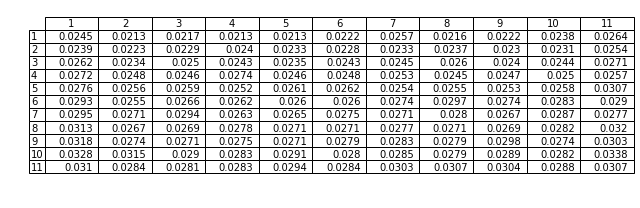

In [14]:
ColLable = [i for i in range(1, 12)]
RowLable = [i for i in range(1, 12)]
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('off')
ax.axis('tight')

ax.table(cellText=RNN_Encoder_NMAE_table, rowLabels= RowLable, colLabels = ColLable, loc='center')
fig.tight_layout()
plt.show()

Text(0, 0.5, 'NMAE value')

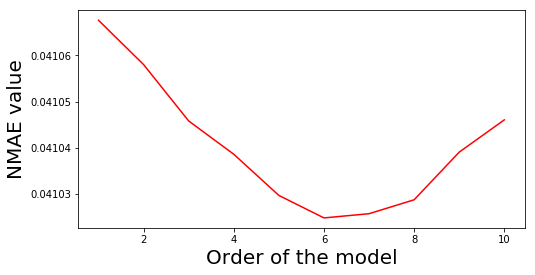

In [525]:
# AR model
AR_history = Y_train.to_numpy()
AR_NMAE = []
x_axis = [i for i in range(1,11)]

# Order change from 1 to 10
for i in range(1, 11):
    AR_model = AR(AR_history)
    AR_model_fit = AR_model.fit(maxlag = i)
    AR_pred = AR_model_fit.predict(len(AR_history),len(AR_history)+len(Y_test_np)-1)
    AR_NMAE.append(CalculateNMAE(AR_pred, Y_test_np))
    
# Plot
plt.figure(num =1, figsize=(8,4))
plt.plot(x_axis,AR_NMAE, color = 'r')
plt.xlabel('Order of the model', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

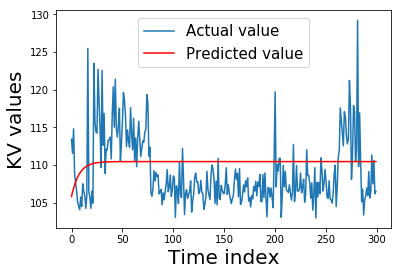

In [517]:
# AR model, plot the predicted and measured value for first 300 samples

AR_history = Y_train.to_numpy()
AR_pred = []
for i in range(300):
    AR_model = AR(AR_history)
    AR_model_fit = AR_model.fit(maxlag = 3)
    pred = AR_model_fit.predict(len(AR_history),len(AR_history))
    AR_history = np.append(AR_history,pred)
#     print(pred)
    AR_pred.append(pred)
plt.plot(Y_test_np[:300])
plt.plot(AR_pred, color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

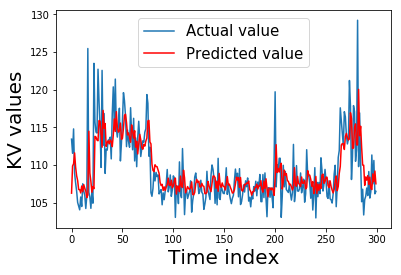

In [518]:
# Plot 300 samples for AR if we put the measured test value into the model

Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()

AR_model = AR(Y_train_np)
AR_NMAE_li = []
for i in range(1,11):
    AR_model_fit = AR_model.fit(maxlag = i)
    window = AR_model_fit.k_ar
    coef = AR_model_fit.params
    # walk forward over time steps in test
    AR_history = Y_train_np[len(Y_train_np)-window:]
    AR_history = [AR_history[i] for i in range(len(AR_history))]
    AR_predictions = list()
    for t in range(len(Y_test)):
        length = len(AR_history)
        lag = [AR_history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = Y_test_np[t]
        AR_predictions.append(yhat)
        AR_history.append(obs)
    AR_NMAE_li.append(CalculateNMAE(AR_predictions, Y_test_np))
plt.plot(Y_test_np[:300])
plt.plot(AR_predictions[:300], color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

Text(0, 0.5, 'NMAE value')

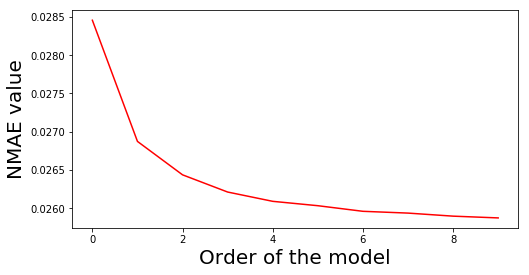

In [403]:
# NMAE for the model above

plt.figure(num =1, figsize=(8,4))
plt.plot(AR_NMAE_li, color = 'r')
plt.xlabel('Order of the model', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

In [526]:
# ARMA model and calculate the NMAE

ARMA_NMAE=[]
for i in range (1, 11):
    model = ARMA(Y_train_np, order=(1, i))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1)
    print(CalculateNMAE(yhat, Y_test_np))
    ARMA_NMAE.append(CalculateNMAE(yhat, Y_test_np))


0.04104079192763099
0.0410544567754157
0.04104817070240546
0.04104156553433927
0.04103837290069913
0.04103957732703066
0.04103859361145934
0.041043530922402795
0.041045126115802875
0.04104537728969509


Text(0, 0.5, 'NMAE value')

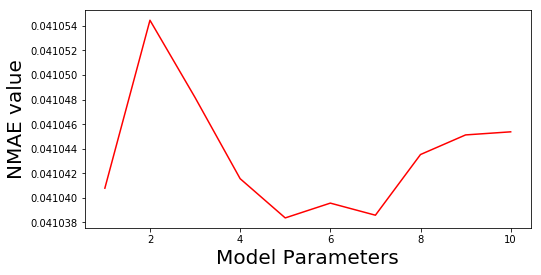

In [527]:
# Plot ARMA NMAE value

plt.figure(num = 1, figsize=(8,4))
plt.plot([i for i in range(1,11)], ARMA_NMAE, color = 'r')
plt.xlabel('Model Parameters', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

0.04104079192763099


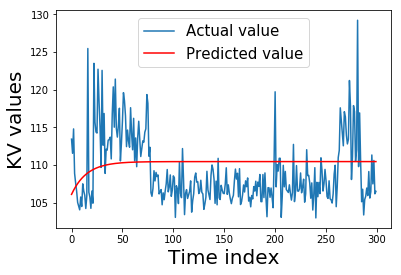

In [543]:
# Plot first 300 samples using ARMA

ARMA_NMAE_plot=[]
model_plot = ARMA(Y_train_np, order=(1, 1))
model_fit_plot = model_plot.fit(disp=False)
# make prediction
yhat_plot = model_fit_plot.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1)
print(CalculateNMAE(yhat_plot, Y_test_np))
ARMA_NMAE_plot.append(CalculateNMAE(yhat_plot, Y_test_np))

plt.plot(Y_test_np[:300])
plt.plot(yhat_plot[:300], color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

In [534]:
# ARIMA model, calculate the NMAE value

ARIMA_NMAE=[]
for i in range(1,11):
    model = ARIMA(Y_train_np, order=(i,1,i))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(len(Y_test_np))[0]
    print(CalculateNMAE(output, Y_test_np))
    ARIMA_NMAE.append(CalculateNMAE(output, Y_test_np))

0.045900949963709026
0.044583472672997185
0.0450726848190927
0.04464078026803061
0.04505174071500897
0.04478680823175071


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.044426865348396155


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.04522049226962056


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.04186655805447044
0.0461346931010413


/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0, 0.5, 'NMAE value')

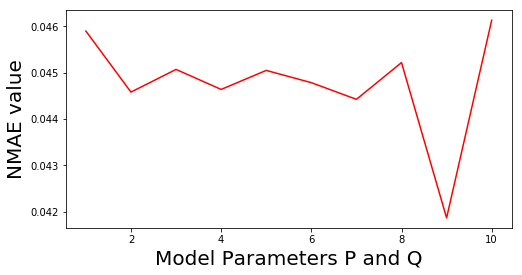

In [544]:
# Plot NMAE value

plt.figure(num = 1, figsize=(8,4))
plt.plot([i for i in range(1,11)], ARIMA_NMAE, color = 'r')
plt.xlabel('Model Parameters P and Q', fontsize=20)
plt.ylabel('NMAE value', fontsize=20)

0.045900949963709026


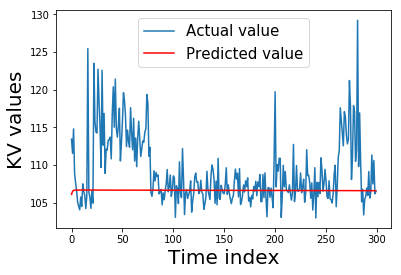

In [541]:
# PLot 300 samples using ARIMA model

ARIMA_NMAE_PRD=[]

model_PRD = ARIMA(Y_train_np, order=(1,1,1))
model_fit_PRD = model_PRD.fit(disp=0)
output_PRD = model_fit_PRD.predict(len(Y_train_np), len(Y_train_np)+len(Y_test_np)-1, typ='levels')
print(CalculateNMAE(output_PRD, Y_test_np))
ARIMA_NMAE_PRD.append(CalculateNMAE(output_PRD, Y_test_np))


plt.plot(Y_test_np[:300])
plt.plot(output_PRD[:300], color = 'r')
plt.xlabel('Time index', fontsize=20)
plt.ylabel('KV values', fontsize=20)
plt.legend(('Actual value','Predicted value'), loc = 'best', fontsize=15)

Text(0, 0.5, 'values of WritesAvg')

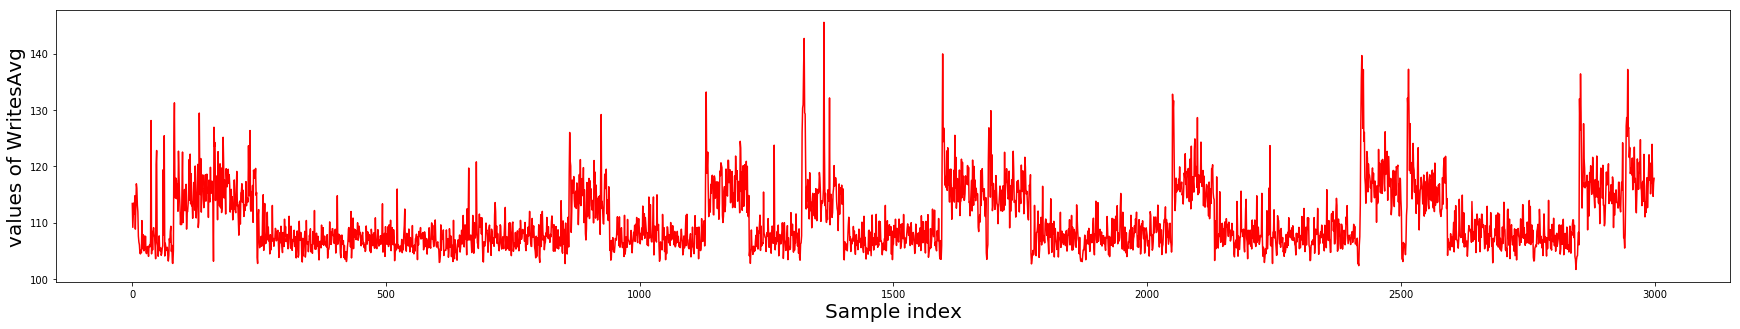

In [573]:
plt.figure(num=1, figsize=(30, 5))

plt.plot(Y_BackToDF.sort_index(axis = 0).iloc[:3000],color='r')

font_size = 20
plt.xlabel('Sample index', fontsize=font_size)
plt.ylabel('values of WritesAvg', fontsize=font_size)

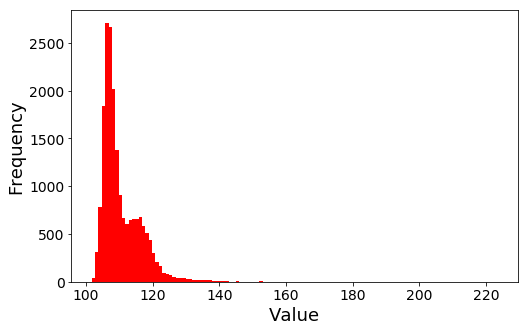

In [572]:
plt.figure(num = 1, figsize=(8, 5))
Y_sample_plt = Y_BackToDF.to_numpy()
font_size = 18
plt.hist(Y_sample_plt, bins=int(Y_sample_plt.max()-Y_sample_plt.min()),color = 'r')

plt.xlabel('Value', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.tick_params(axis='both', which='both', labelsize=font_size-4)

In [579]:
print(Y_notime.shape[0])
print(X_notime.shape[1])

19444
1723
